# ECSE 415 Group Project

##  Part I.  Classification

(This jupyter notebook is run on a Windows laptop)

#### 1. Description of the contents of the dataset (number of samples and image size, for each label).

The original dataset contains over 600k images with 11 categories. Since loading 600k images will take too much time for the training, we decided to randomly choose 300 images for each category from the original dataset. (The randomness is realized through the use of os.listdir() method, which arbitraryly return a list containing the names of the entries in the directory given by path.)

So we loaded in total 11 * 300 = 3300 images into a list named "train" to store the origianl images. Another list named "class_label" stores the groud truth labels for the corresponding images (so in total 3300 labels).The index for the images and corresponding labels stored in "train" and "class_label" matches. 

Since we found that some of the database images are horizontal rectangle, some are vertical rectangle, and also most of their shape are not far away from square (also the average of horizontal rectangle and vertical rectangle can be considered as roughly square). Therefore, we decided to resize all the 3300 loaded images into square. At the same time, to alleviate the computation burden, we resize the images to 128 x 128, and convert the images all to gray scale, so as to reduce computational issues (time).

#### 2. Explanation of feature extraction method.

We use the HoG feature descriptor to extract the training/validating images' features. The idea behind HOG feature descriptor is that the local appearance and shape within an image can be described by the distribution of intensity gradients or edge direction. It is a variation of SIFT feature descriptor which computes magnitude weighted edge orientation histograms. And since the objects we classify have different sizes from the image training set, HOG is our ideal descriptor due to its no compensation in scale. In addition, HoG is applied to larger image patches, which may have internal changes in illumination. That is why we choose HOG descriptor as our feature extractor for the dataset.
    
The HOG pipeline includes the following procedure: 
    
    1) Compute the gradients of the input images;
    2) Accumulate the weighted votes for gradient orientation over spatial cells;
    3) Normalise contrast within overlapping block of cells
    4) Collect HOGs for all blocks for detection windows

#### 3. Explanation of how the feature extraction parameters were selected.

There are in total 3 feature extraction parameters related to the HoG feature descriptor, namely "block_size", "cell_size", and "n_bins". (Theoretically, there should also be parameter "block_overlap". But in our case, the method HoGFeatures(img) that is used to extract the feature only has three input arguments, and the corresponding block_overlap is calculated according to the input arguments. Therefore, here the feature extraction parameters that are free to change are only the three that mentioned on the first line above.

- Block_size: number of cells in a block (a 2-element vector). A large block size value reduces the ability to suppress local illumination changes. Because of the number of pixels in a large block, these changes may get lost with averaging. Reducing the block size helps to capture the significance of local pixels. Smaller block size can help suppress illumination changes of HOG features.

- Cell_size: size of HOG cell (a 2-element vector). To capture large-scale spatial information, increase the cell size.

- nbins: number of orientation histogram bins. To encode finer orientation details, increase the number of bins. Increasing this value increases the size of the feature vector, which requires more time to process.

We chose the three parameters according to the above characteristics:

- For the block_size: since smaller block size can help suppress illumination changes of HoG features, we want to choose a smaller block size. After testing the case block_size = (2, 2), (4, 4), (8, 8). We decided to choose block_size = (2, 2).

- For the cell_size: since we need to capture large-scale spatial information (larger image patch) in this case, so we finally select cell_size = (8, 8). (We tested the case when cell_size = (2, 2), (4, 4), (8, 8), and found that indeed cell_size = (8, 8) gives us a bit better reults). 

- For the nbins: since we want to find a balance between orientation details and process time, so we decided to choose nbins = 8.

Therefore, to summarize, the final HoG feature extraction parameters selected are:
- block_size = (2, 2)
- cell_size = (8, 8)
- nbins = 8

Below is part of the testing result obtained running by another MAC laptop. Although due to the different internal random mechanism between Windows and MAC, and to reduce the testing time, we reduce the number of loading images down to 150 images per category during testing, but the trend follows/confirms what we conclude above: (Also, it seems that the combination we chose consumes the least computation time, compared to the other two, which makes us able to train more images with the usage of same amount of time, to increase the prediction accuracy)

- block_size = (2, 2)
- cell_size = (8, 8)
- nbins = 8

- SVM classifier: average classificaton accuracy 45.8%
- KNeighborsClassifier: average classification accuracy 43%

-----------------------------
- block_size = (4, 4)
- cell_size = (4, 4)
- nbins = 8

- SVM classifier: average classificaton accuracy 44.15%
- KNeighborsClassifier: average classification accuracy 41.029%

-----------------------------
- block_size = (8, 8)
- cell_size = (2, 2)
- nbins = 8

- SVM classifier: average classificaton accuracy 42.257%
- KNeighborsClassifier: average classification accuracy 37.4%

#### 4. Description of cross-validation method.

Cross-validation is a method of evaluating how well a model will generalize. It evaluates how sensitive model is to the training data. Cross-validation partitions the available dataset into two sets called training set and validation set. A model is trained on the training set and evaluated on validation set. Here, we use 10-fold cross validation, which means the total loaded dataset is partitioned into 10 equal subsets. Each subset serves as a validation set exactly once. Therefore, the cross-validation loop has 10 iterations. For each iteration, one subset is selected for validation, and the remaining 9 subsets are used to train the model.

We use the built-in function split() from the KFold library to get the "train_index" and "valid_index" for each fold, which are the corresponding index array that will be used to separate the training set and validation set for the current fold. Then according to the obatined index array, we get the training data and validation data in current fold (see the code snapshot below), which are used to do the following model training based on training set, and classification prediction of the validation set based on the trained model.

    # Get our training data in this fold
    kX_train = X_train[train_index, :]  # all training images
    kY_train = Y_train[train_index]     # all training labels (ground truth)
    
    # Get our validation data in this fold
    kX_valid = X_train[valid_index, :]   # all validating images
    kY_valid = Y_train[valid_index]      # all validating labels (ground truth)

Instead of evaluating the performance of the classifier by independently using a subset of images to train the model and another different subset of images to test the trained model, cross-validation evaluates how sensitive a model is to the training data. The performance on the 10 validation subsets form a distribution which is used to evaluate the model's ability to generalize to new datasets. For example, if the 10 calculated accuracies across validations have a large standard deviation, this means the trained model may not be stable enough to generalize to new datasets. It is possible that the prediction is with high accuracy for one test set, but the prediction accuracy is not stable. If we change the testing set into some other dataset, the classifer may obtain a low prediction accuracy. There will be no confirmation of the generalization of the trained classifier without using the cross-validation method.

#### 5. Evaluation of performance and interpretation of results (from Section 2.1). 

1) Definitioin of accuracy, precision, and recall:

    - Accuracy: the number of correct predictions divided by the total predictions.
    - Precision: of the predictions made for class C, what fraction was correct.
    - Recall: of the samples for class C, how many were correctly predicted.

Therefore, the "precision" and "recall" are class-based.


2) To calculate the precision and recall, we first need to know the corresponding value of True Postive (TP), False Positive (FP), and False Negative (FN). Please see the code below, a function named "compute_precision_recall(GT_f, prediction_f)", for a detailed implementation of the calculation.


3) 

    - Average classification accuracy across validations = 60.56277056277056 %
    - Standard deviation =  0.02867944948060932

From the standard deviation, we can find that the obtained 10 accuracies are relatively stable. Therefore, by using the cross validation method, we could know that our trained model will be basically able to generalize to new datasets. (Due to the shuffle we use or whether use MAC or Windows to run, the values obtained for each running will not be exactly the same).

4)  Classed-based average precision and recall across validations (Due to the shuffle we use or whether use MAC or Windows to run, the values obtained for each running will not be exactly the same):


    - Current class: bus
    - Average precision: 66.81025453659724 %
    - Average recall: 66.48559395515916 %


    - Current class: pedestrian
    - Average precision: 64.26403228096592 %
    - Average recall: 59.971364829611865 %


    - Current class: bicycle
    - Average precision: 59.2976282179405 %
    - Average recall: 55.86738816738816 %


    - Current class: car
    - Average precision: 62.7044547287514 %
    - Average recall: 65.56925654325035 %


    - Current class: background
    - Average precision: 64.89207712577279 %
    - Average recall: 72.61679299845943 %


    - Current class: articulated_truck
    - Average precision: 54.727091188381515 %
    - Average recall: 64.00867097411046 %


    - Current class: motorcycle
    - Average precision: 63.53939393939394 %
    - Average recall: 59.82232361219184 %


    - Current class: non_motorized_vehicle
    - Average precision: 50.071944963249315 %
    - Average recall: 50.469708230577794 %


    - Current class: pickup_truck
    - Average precision: 62.259873278895014 %
    - Average recall: 66.89744026905827 %


    - Current class: single_unit_truck
    - Average precision: 61.25493787258493 %
    - Average recall: 48.65365570625364 %


    - Current class: work_van
    - Average precision: 60.9118651845388 %
    - Average recall: 58.81494288305434 %

5)  Are these values consistent with the accuracy?

The obtained average precision and recall are mostly within +-10% fluctuation around the calculated average accuracy. They are basically consistent with the accuracy. This can be verified from both our statistic results and confusion matrix. (However, theoretically, since in our case, the dataset is not well-balanced. And since precision and recall are class-based, they may better represent the data within a specific class compared to the accuracy. Since accuracy is the average of all classes.)

6) Are they more representative of the dataset?

Since accuracy, precision, and recall describe different characteristics of a dataset. For example, Accuracy is the proximity of measurement results to the true value. Accuracy does not perform well with imbalanced data sets. Precision is the repeatability, or reproducibility of the measurement. And recall is of the samples for class C, how many were correctly predicted. Therefore, these three metrics describe charactertistics of the whole dataset from different aspects.

Additionally, we have to take the fact that the dataset is not well-balanced in to consideration. Therefore, to better represent the dataset, we need to evaluate all these three metrics. Having accuracy, precision and recall would be more representative of the data rather than only using accuracy. Also, since precision and recall are class-based, and due to imbanlanced dataset. For some classes, precision and recall may better represent the data within that specific class compared to the accuracy, since from accuracy, we can only know the average from all classes.

7) In what situations would you expect precision and recall to be a better reflection of model performance than accuracy?

When the dataset is not well-balanced (our case), it is expected that precision and recall are better reflections of model performance than accuracy. For example, in our case, we use shuffle to mix all the training images across all the classes, thus the training and testing images from each class are different in quantity. Since the dataset isn't well-balanced, doing well on the classes with lots of data would mask the fact that doing poorly on classes with less data. This is why precision and recall would be a better reflection of the model performance for imbalanced dataset.

8) A confusion matrix on a validation set. Are any of the classes diffcult for your classifier? Discuss.

The image of confusion matrices across validations could be found from the code result below. (For our matrix, the lighter color means larger normalized value, and darker color means smaller normalized value.) From the result of confusion matrix, we could find that the performance of classfier is good. Since most of the matrix only has light color along the diagonal, which means correctly classified. And there are only a few cases where some entries which are off-diagonal, but have a color between light and dark, which means the classifier is confusing one class for another. For example, it is observed that the pairs "bicycle and non_motorized_vehicle" is a bit difficult to classify for the classifier. Since the confusion matrix for the entry of "bicycle and non_motorized_vehicle" is not on diagonal, but the color of this entry is lighter than the other off-diagonal part. 

#### Repeat using a (non-deep learning) classifier of your choice.

In addition to using the SVM classifier, we have repeated the classification process by using the K-nearest-neighbors (KNN) classifier. KNN is able to predict the result with similar (a little bit higher for the current running result) average accuracy (62.55411255411255 %) comparing to SVM classifier's result (60.56277056277056 %). And the standard deviation for KNN is a bit larger than SVM's (KNN: 0.043688641123784316 Vs. SVM: 0.02867944948060932). We tested several time, there are also cases when the accuracy from SVM is a bit higher than KNN (due to the shuffle we mentioned before). Therefore, these two classifiers have similar performance. The Confusion matrix images and the full statistic results (average accuracy, precision, and recall) of using KNN classifier can be seen from the below code (on the last part of the code).

#### 6. Inclusion of well-documented code (separate from report)

The entire code, together with the obtained results (performances) and comments are shown below.

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier

In [20]:
def HoGFeatures(img):
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # create HoG Object
    # winSize is the size of the image cropped to an multiple of the cell size
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                  img.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)
    
    n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
    
    # Compute HoG features
    hog_feats = hog.compute(img)\
               .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[0], block_size[1], nbins) \
               .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
    
    # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
    # Indexing is by rows then columns.
    
    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], nbins), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)
    
    for off_y in range(block_size[0]):
        for off_x in range(block_size[1]):
            gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                      off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                       off_x:n_cells[1] - block_size[1] + off_x + 1] += 1
    
    # Average gradients
    gradients /= cell_count
    
    return gradients

In [21]:
# parameters to be changed
size = (128, 128)
train_image_num = 300

class_num = 11

block_size = (2, 2)
cell_size = (8, 8)
nbins = 8

clf = svm.SVC(gamma=0.001, C=100.)
knn = KNeighborsClassifier (n_neighbors=3)

train_size_fraction=0.7

In [22]:
class_label = []
train = []

# load the images
directory_bus = "./MIO-TCD-Classification/train/bus/"
load_bus = os.listdir(directory_bus)
bus = []

directory_pedestrain = "./MIO-TCD-Classification/train/pedestrian/"
load_pedestrain = os.listdir(directory_pedestrain)
pedestrain = []

directory_bicycle = "./MIO-TCD-Classification/train/bicycle/"
load_bicycle = os.listdir(directory_bicycle)
bicycle = []

directory_car = "./MIO-TCD-Classification/train/car/"
load_car = os.listdir(directory_car)
car = []

directory_background = "./MIO-TCD-Classification/train/background/"
load_background = os.listdir(directory_background)
background = []

directory_articulated_truck = "./MIO-TCD-Classification/train/articulated_truck/"
load_articulated_truck = os.listdir(directory_articulated_truck)
articulated_truck = []

directory_motorcycle = "./MIO-TCD-Classification/train/motorcycle/"
load_motorcycle= os.listdir(directory_motorcycle)
motorcycle = []

directory_non_motorized_vehicle = "./MIO-TCD-Classification/train/non-motorized_vehicle/"
load_non_motorized_vehicle= os.listdir(directory_non_motorized_vehicle)
non_motorized_vehicle = []

directory_pickup_truck = "./MIO-TCD-Classification/train/pickup_truck/"
load_pickup_truck= os.listdir(directory_pickup_truck)
pickup_truck = []

directory_single_unit_truck = "./MIO-TCD-Classification/train/single_unit_truck/"
load_single_unit_truck= os.listdir(directory_single_unit_truck)
single_unit_truck = []


directory_work_van = "./MIO-TCD-Classification/train/work_van/"
load_work_van= os.listdir(directory_work_van)
work_van = []


names = ["bus", "pedestrian", "bicycle", "car", "background", "articulated_truck", "motorcycle", 
         "non_motorized_vehicle", "pickup_truck", "single_unit_truck", "work_van"]

class_list = [bus, pedestrain, bicycle, car, background, articulated_truck, motorcycle, non_motorized_vehicle, 
              pickup_truck, single_unit_truck, work_van]
directory_list = [directory_bus, directory_pedestrain, directory_bicycle, directory_car, directory_background, 
                  directory_articulated_truck, directory_motorcycle, directory_non_motorized_vehicle,
                 directory_pickup_truck, directory_single_unit_truck, directory_work_van]
load_path = [load_bus, load_pedestrain, load_bicycle, load_car, load_background, load_articulated_truck, 
             load_motorcycle, load_non_motorized_vehicle, load_pickup_truck, load_single_unit_truck, load_work_van]


# randomly load 300 images for each category from the original dataset which containing over 600k images.
# In total, the list "train" contains 300 * 11 = 3300 images. And the list "class_label" contains the groud truth labels for these corresponding images.
# The index for the images and corresponding labels stored in "train" and "class_label" matches.
for j in range (class_num):
    
    for i in range(train_image_num):
        img = cv2.cvtColor(cv2.imread(directory_list[j] + load_path[j][i]), cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, size)     
        class_list[j].append(img)
        train.append(img)
        class_label.append(names[j])

# split the "train" and "class_label" into training subset and testing subset
X_train, X_test, Y_train, Y_test = train_test_split(train, class_label, train_size=train_size_fraction, shuffle=True)

# use X_train  Y_train only for training 
print("The total number of images in train list :", len(train))
print("The actual used number of training images used by spliting the traning list: X_train", len(X_train))
print("The actual used number of training labels used by spliting the traning list: Y_train", len(Y_train))



The total number of images in train list : 3300
The actual used number of training images used by spliting the traning list: X_train 2310
The actual used number of training labels used by spliting the traning list: Y_train 2310


C:\Users\xyq\Anaconda3\envs\my_root\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [23]:
# compute and store the HoG features
def HOG (train):
    # Create a list to store HoG features of the training images
    HoGTrain = []

    # loop through all training images, call the HoGFeatures(img) function to compute the corresponding HoG feature 
    # for each training image and store it into HoGTrain[] list
    for i in range(len(train)):
        HoGTrain.append(HoGFeatures(train[i]))
        
    HoGTrain = np.reshape(HoGTrain, (len(HoGTrain), -1))
    return HoGTrain

In [24]:
# plot the confusion matrix
def conf (label, predict, classes): 
    conf_plot = confusion_matrix(label, predict)
    conf_plot = conf_plot.astype('float') / conf_plot.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(conf_plot)
    plt.title("Normalized Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes, rotation=0)
    plt.colorbar()
    plt.show()


In [25]:
# cast a 1d array to list
def toList(array):
    list = []
    for i in range (array.shape[0]):
        list.append(array[i])
    return list 

In [26]:
# calculate the accuracy 
def accuracy(label, predict):
    score = 0
    for i in range (len(predict)):
        if (label[i] == predict[i]):
            score = score + 1
    return score/len(predict)
 

In [27]:
# input two arrays of different size
# compute number of TPs (number of duplicates in two arrays)
def distribution (GT, pre):
    TP = 0
    for i in range (len(GT)):
        if GT[i] in pre:
            TP = TP + 1
    return TP
    

In [28]:
# compute both precision and recall
def compute_precision_recall(GT_f, prediction_f):
    
    print("Number of Ground Truth of current class", len(GT_f))
    print("Number of Prediction of current class", len(prediction_f))

    # cast list to array
    GT_f = np.array(GT_f)
    prediction_f = np.array(prediction_f)

    precision_list = []
    recall_list = []
    
    for i in range(len(names)):
        GT_idx = np.where(GT_f==names[i])
        pre_idx = np.where(prediction_f==names[i])
        print("---------------------------------------------------------------")
        print("Current class: ", names[i])
        print("Prediction index", pre_idx[0])
        print("Groud Truth index", GT_idx[0])
    
        # matched: truth positive
        true_pos = distribution(GT_idx[0], pre_idx[0])
        # in gt, but not in pre : false negative 
        false_neg = len(GT_idx[0]) - true_pos
        # in pre but not in gt : false positive
        false_pos = len(pre_idx[0]) - true_pos
    
        print("Number of true positives:", true_pos)
        print("Number of false positives:", false_pos)
        print("Number of false negatives:", false_neg)
       
        # calculate precision and recall  
        if((false_pos+true_pos)== 0):
            precision = 0
        else:
            precision = true_pos / (true_pos + false_pos)
        
        if((false_neg+true_pos)== 0):
            recall = 0
        else:
            recall = true_pos / (true_pos + false_neg)
        
        
        precision_list.append(precision)
        recall_list.append(recall)
        
        print("Precision for", names[i], "is", precision * 100, "%")
        print("Recall for", names[i], "is", recall*100, "%")
    
    return precision_list, recall_list


### Contains Confusion matrix images for each fold of cross validations

(Please scroll down of the running output to see the confusion matrices for each fold)

Cross-validation: fold 1
------------------------------------------------------------------------
Classification Accuracy---------------------------------- 58.00865800865801 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [ 14  23  24  25  28  33  41  44  53  56  80 132 133 138 142 154 162 169
 172 173 174 183 192 199 212 213 224 226]
Groud Truth index [ 14  23  24  28  33  41  46  69  73  80  89 132 134 139 142 154 162 169
 173 174 180 183 199 208 224 226]
Number of true positives: 18
Number of false positives: 10
Number of false negatives: 8
Precision for bus is 64.28571428571429 %
Recall for bus is 69.23076923076923 %
--------------------------------------------------

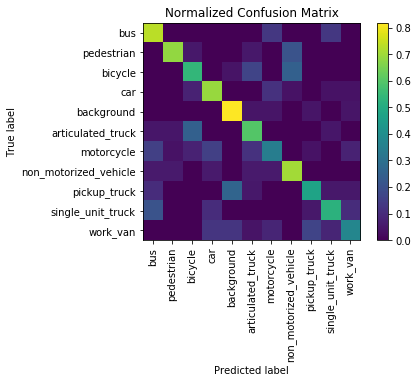





Cross-validation: fold 2
------------------------------------------------------------------------
Classification Accuracy---------------------------------- 57.57575757575758 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [  3   8  23  47  54  71  74 114 136 138 169 184 185 187 202 215 216]
Groud Truth index [  8  50  54  74 114 123 136 185 187 199 202 215 216]
Number of true positives: 10
Number of false positives: 7
Number of false negatives: 3
Precision for bus is 58.82352941176471 %
Recall for bus is 76.92307692307693 %
---------------------------------------------------------------
Current class:  pedestrian
Prediction index [ 12  24  40  42  51  52  55  56  64 

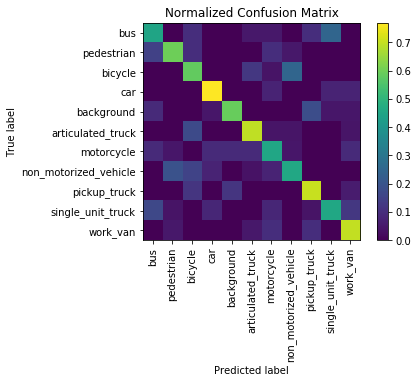





Cross-validation: fold 3
------------------------------------------------------------------------
Classification Accuracy---------------------------------- 61.904761904761905 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [ 13  29  37  39  41  48  63  91  95  96  99 105 106 109 139 157 166 178
 182 207 213 225 229]
Groud Truth index [ 37  39  41  48  63  67  68  91  95  96 106 109 166 182 196 213 225 229]
Number of true positives: 15
Number of false positives: 8
Number of false negatives: 3
Precision for bus is 65.21739130434783 %
Recall for bus is 83.33333333333334 %
---------------------------------------------------------------
Current class:  pedestrian
Predicti

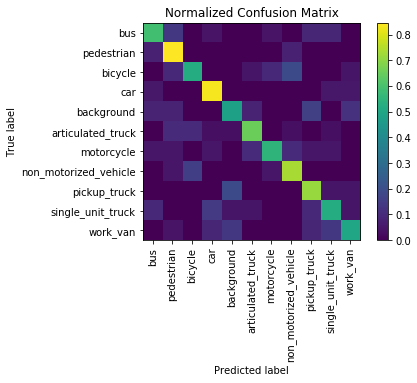





Cross-validation: fold 4
------------------------------------------------------------------------
Classification Accuracy---------------------------------- 62.33766233766234 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [  5  21  36  64  80  83 113 120 137 142 151 160 161 178 193 197 199 208
 216 223 229]
Groud Truth index [  5  36  45  68  80  84  90 108 120 125 137 151 157 160 161 165 193 199
 205 208 216 223 229]
Number of true positives: 14
Number of false positives: 7
Number of false negatives: 9
Precision for bus is 66.66666666666666 %
Recall for bus is 60.86956521739131 %
---------------------------------------------------------------
Current class:  pedestr

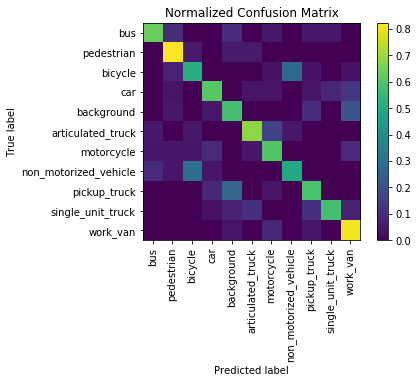





Cross-validation: fold 5
------------------------------------------------------------------------
Classification Accuracy---------------------------------- 61.038961038961034 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [ 13  21  31  47  54  56  78  95  96 105 111 116 128 155 175 192 195]
Groud Truth index [  5  17  21  47  56  58  70  78 105 116 155 175 192 195 206]
Number of true positives: 10
Number of false positives: 7
Number of false negatives: 5
Precision for bus is 58.82352941176471 %
Recall for bus is 66.66666666666666 %
---------------------------------------------------------------
Current class:  pedestrian
Prediction index [ 19  23  27  38  79  88  94

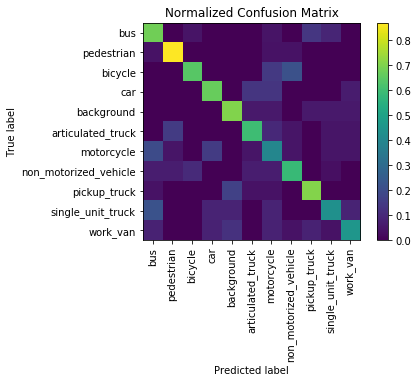





Cross-validation: fold 6
------------------------------------------------------------------------
Classification Accuracy---------------------------------- 64.06926406926407 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [  4  15  18  61  92 114 115 116 134 142 160 166 173 182 186]
Groud Truth index [ 12  15  18  29  39  82  92 100 114 115 116 134 142 155 160 166 173 182
 197 218]
Number of true positives: 12
Number of false positives: 3
Number of false negatives: 8
Precision for bus is 80.0 %
Recall for bus is 60.0 %
---------------------------------------------------------------
Current class:  pedestrian
Prediction index [ 25  36  45  53  54  66  68  74  75  78  

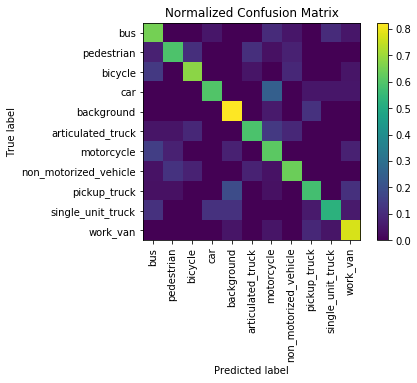





Cross-validation: fold 7
------------------------------------------------------------------------
Classification Accuracy---------------------------------- 64.06926406926407 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [ 14  18  20  21  26  40  52  59  60  63  95 103 109 128 151 171 181 182
 185 224]
Groud Truth index [ 18  20  21  33  40  59  60  63  89  95 104 109 126 128 137 146 151 169
 181 182 221 224 226]
Number of true positives: 14
Number of false positives: 6
Number of false negatives: 9
Precision for bus is 70.0 %
Recall for bus is 60.86956521739131 %
---------------------------------------------------------------
Current class:  pedestrian
Prediction in

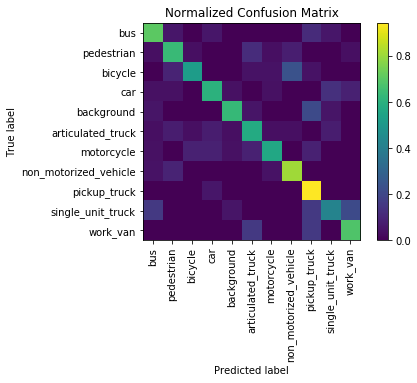





Cross-validation: fold 8
------------------------------------------------------------------------
Classification Accuracy---------------------------------- 61.471861471861466 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [  5  14  40  45  78 106 109 111 136 152 153 156 165 166 171 174 176 188
 207 213 221]
Groud Truth index [  6  12  13  14  16  40  45  66  77 106 108 109 111 136 141 153 165 166
 171 174 176 207 213 221 227]
Number of true positives: 16
Number of false positives: 5
Number of false negatives: 9
Precision for bus is 76.19047619047619 %
Recall for bus is 64.0 %
---------------------------------------------------------------
Current class:  pedestrian


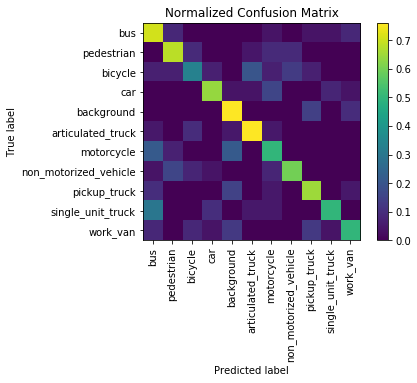





Cross-validation: fold 9
------------------------------------------------------------------------
Classification Accuracy---------------------------------- 54.54545454545454 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [  2   6   8  16  35  36  42  43  49  51  60  65  70  83  87  91 100 109
 123 140 160 163 181 182 185 199 201 204 226 228]
Groud Truth index [  8  36  42  49  51  62  65  70  73  76  83  87  91 100 104 109 115 123
 134 136 149 151 163 181 197 201 228]
Number of true positives: 17
Number of false positives: 13
Number of false negatives: 10
Precision for bus is 56.666666666666664 %
Recall for bus is 62.96296296296296 %
--------------------------------

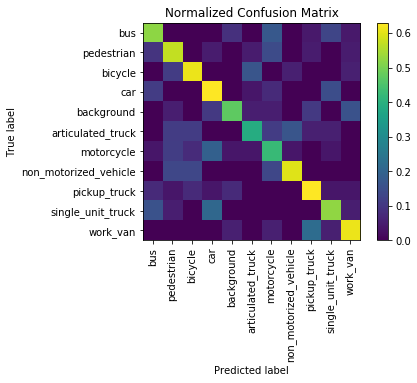





Cross-validation: fold 10
------------------------------------------------------------------------
Classification Accuracy---------------------------------- 60.60606060606061 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [ 10  25  34  48  50  55  61  74  81  87 101 106 115 121 133 151 175 189
 200 222 228]
Groud Truth index [ 10  22  23  25  34  48  50  52  55  74  87 101 103 106 108 121 151 163
 170 175 180 184 195 200 222]
Number of true positives: 15
Number of false positives: 6
Number of false negatives: 10
Precision for bus is 71.42857142857143 %
Recall for bus is 60.0 %
---------------------------------------------------------------
Current class:  pedestrian

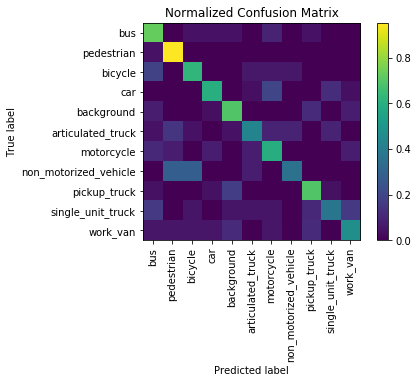

In [29]:
# svm classifier
# cross validation

# Initialize the class with the number of folds:
kf_splitter = KFold(n_splits=10)


X_train = np.array(X_train)
Y_train = np.array(Y_train)

a = 0
accuracy_array = np.zeros(10)
precision_matrix = np.zeros((10, 11))
recall_matrix = np.zeros((10, 11))
total_prediction = []
total_GT = []

# train_index= 9/10 X_train; valid_index =  1/10 X_train
for train_index, valid_index in kf_splitter.split(X_train):   #10
    # print(valid_index[0])
    # Get our training data in this fold
    kX_train = X_train[train_index, :]  # all training images
    kY_train = Y_train[train_index]     # all training labels
    
    # Get our validation data in this fold
    kX_valid = X_train[valid_index, :]   # all testing images
    kY_valid = Y_train[valid_index]      # all testing labels
    
    # Hog 
    kX_train = HOG (kX_train)
    clf.fit(kX_train, kY_train)
    
    kX_valid= HOG (kX_valid)
    
    # svm prediction
    prediction_valid = clf.predict(kX_valid)
    
    print("Cross-validation: fold", str(a+1))
    print("------------------------------------------------------------------------")
    
    # cast 1d array to list 
    kY_valid = toList(kY_valid)
    prediction_valid = toList(prediction_valid)
    
    # for accuracy calculation
    acc = accuracy (kY_valid, prediction_valid)
    print("Classification Accuracy----------------------------------", acc*100, "%")
    print("------------------------------------------------------------------------\n")
    print("Calculation for Precision and Recall:")
    print("-------------------------------------------------------------------")
    
    precision, recall = compute_precision_recall(kY_valid, prediction_valid)
    
    accuracy_array[a] = acc
    precision_matrix[a, :] = precision
    recall_matrix[a, :] = recall
    
    a = a+1

    # call above function to plot the confusion matrix
    conf (kY_valid, prediction_valid, names)
    print("\n")
    print("\n")
  

In [30]:
# print out the overall result, includes: average accuracy, precision and recall for each class

print("Average accuracy across validations:", np.mean(accuracy_array)*100, "%") 
print("Standard deviation:", np.std(accuracy_array))

print("\n")
print("Average precision and recall across validations for each class:") 

average_precision = precision_matrix.mean(0)
average_recall = recall_matrix.mean(0)
for i in range(11):
    print("----------------------------------------------------------------------")
    print("Current class:", names[i])
    print("Average precision:", average_precision[i]*100, "%")
    print("Average recall:", average_recall[i]*100, "%")


Average accuracy across validations: 60.56277056277056 %
Standard deviation: 0.02867944948060932


Average precision and recall across validations for each class:
----------------------------------------------------------------------
Current class: bus
Average precision: 66.81025453659724 %
Average recall: 66.48559395515916 %
----------------------------------------------------------------------
Current class: pedestrian
Average precision: 64.26403228096592 %
Average recall: 59.971364829611865 %
----------------------------------------------------------------------
Current class: bicycle
Average precision: 59.2976282179405 %
Average recall: 55.86738816738816 %
----------------------------------------------------------------------
Current class: car
Average precision: 62.7044547287514 %
Average recall: 65.56925654325035 %
----------------------------------------------------------------------
Current class: background
Average precision: 64.89207712577279 %
Average recall: 72.616792998459

#### Repeat the above procedures using a K-Nearest-Neighbors (KNN) classifier:
NOTE: Since the KNN classifier uses the same variables' names as SVM classifier, to avoid the results being mixed, please run this jupyter notebook in order. Thank you!

Cross-validation: fold 1
-------------------------------------------------------------------------
Classification Accuracy---------------------------------- 63.20346320346321 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [ 11  14  23  24  25  27  33  41  46  68  73  75  80  89 102 120 132 133
 139 141 142 154 162 167 169 172 173 174 182 183 199 212 224 228]
Groud Truth index [ 14  23  24  28  33  41  46  69  73  80  89 132 134 139 142 154 162 169
 173 174 180 183 199 208 224 226]
Number of true positives: 20
Number of false positives: 14
Number of false negatives: 6
Precision for bus is 58.82352941176471 %
Recall for bus is 76.92307692307693 %
-------------------------

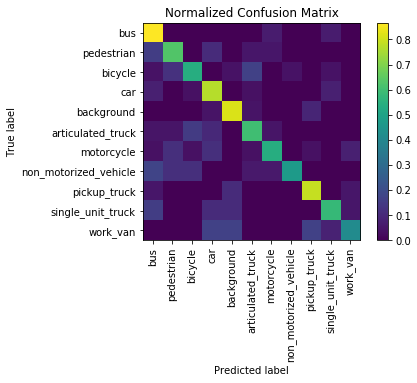





Cross-validation: fold 2
-------------------------------------------------------------------------
Classification Accuracy---------------------------------- 52.81385281385281 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [  8   9  12  28  32  36  50  66  74  95  99 105 114 123 133 140 148 152
 168 185 187 194 198 202 215 216]
Groud Truth index [  8  50  54  74 114 123 136 185 187 199 202 215 216]
Number of true positives: 10
Number of false positives: 16
Number of false negatives: 3
Precision for bus is 38.46153846153847 %
Recall for bus is 76.92307692307693 %
---------------------------------------------------------------
Current class:  pedestrian
Prediction inde

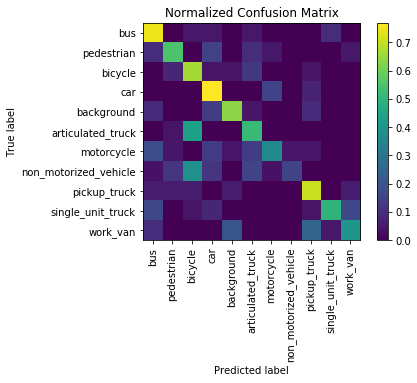





Cross-validation: fold 3
-------------------------------------------------------------------------
Classification Accuracy---------------------------------- 66.66666666666666 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [  3  37  39  41  48  63  66  73  89  91  96 101 106 109 139 141 144 163
 165 166 182 196 205 207 213 225 229]
Groud Truth index [ 37  39  41  48  63  67  68  91  95  96 106 109 166 182 196 213 225 229]
Number of true positives: 15
Number of false positives: 12
Number of false negatives: 3
Precision for bus is 55.55555555555556 %
Recall for bus is 83.33333333333334 %
---------------------------------------------------------------
Current class:  pe

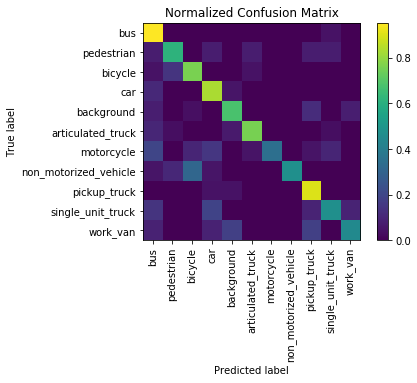





Cross-validation: fold 4
-------------------------------------------------------------------------
Classification Accuracy---------------------------------- 62.77056277056276 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [  5   8  28  31  36  42  68  79  80  83  90 102 120 137 138 151 160 161
 167 188 193 199 205 208 216 219 223 229]
Groud Truth index [  5  36  45  68  80  84  90 108 120 125 137 151 157 160 161 165 193 199
 205 208 216 223 229]
Number of true positives: 17
Number of false positives: 11
Number of false negatives: 6
Precision for bus is 60.71428571428571 %
Recall for bus is 73.91304347826086 %
---------------------------------------------------------

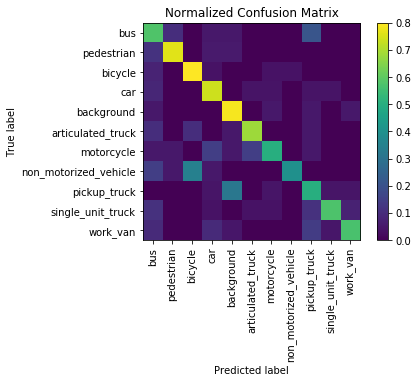





Cross-validation: fold 5
-------------------------------------------------------------------------
Classification Accuracy---------------------------------- 58.44155844155844 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [ 18  21  47  48  53  56  62  78 105 125 155 175 180 192 195]
Groud Truth index [  5  17  21  47  56  58  70  78 105 116 155 175 192 195 206]
Number of true positives: 9
Number of false positives: 6
Number of false negatives: 6
Precision for bus is 60.0 %
Recall for bus is 60.0 %
---------------------------------------------------------------
Current class:  pedestrian
Prediction index [ 94 102 113 121 129 131 162 169 185 190 196 203]
Groud Truth i

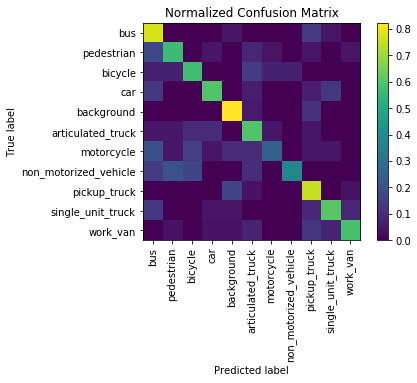





Cross-validation: fold 6
-------------------------------------------------------------------------
Classification Accuracy---------------------------------- 70.12987012987013 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [ 10  15  18  29  39  82  92 100 114 115 116 120 134 141 142 160 173 182
 212 218]
Groud Truth index [ 12  15  18  29  39  82  92 100 114 115 116 134 142 155 160 166 173 182
 197 218]
Number of true positives: 16
Number of false positives: 4
Number of false negatives: 4
Precision for bus is 80.0 %
Recall for bus is 80.0 %
---------------------------------------------------------------
Current class:  pedestrian
Prediction index [ 27  36  49  53  59

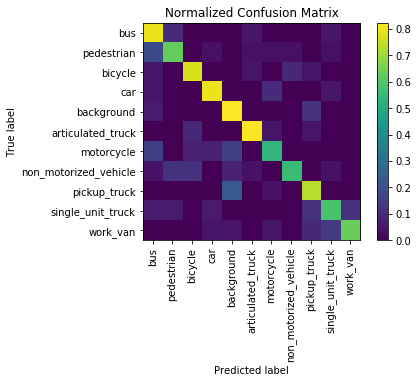





Cross-validation: fold 7
-------------------------------------------------------------------------
Classification Accuracy---------------------------------- 64.5021645021645 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [  0  18  19  20  21  26  40  52  59  60  63  89 104 109 128 146 151 164
 169 181 182 185 188 189 221 224 225]
Groud Truth index [ 18  20  21  33  40  59  60  63  89  95 104 109 126 128 137 146 151 169
 181 182 221 224 226]
Number of true positives: 18
Number of false positives: 9
Number of false negatives: 5
Precision for bus is 66.66666666666666 %
Recall for bus is 78.26086956521739 %
---------------------------------------------------------------

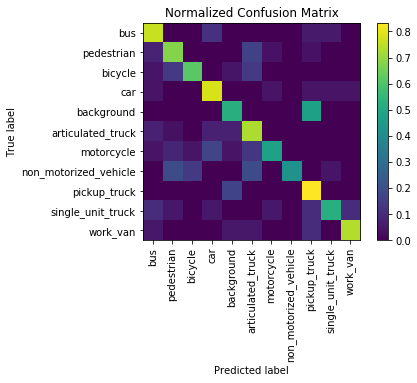





Cross-validation: fold 8
-------------------------------------------------------------------------
Classification Accuracy---------------------------------- 61.904761904761905 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [  0   2   5  12  13  14  40  45  72  77  92  97 106 109 111 136 141 153
 165 166 171 174 176 183 207 210 211 213 221 227]
Groud Truth index [  6  12  13  14  16  40  45  66  77 106 108 109 111 136 141 153 165 166
 171 174 176 207 213 221 227]
Number of true positives: 21
Number of false positives: 9
Number of false negatives: 4
Precision for bus is 70.0 %
Recall for bus is 84.0 %
---------------------------------------------------------------
Cur

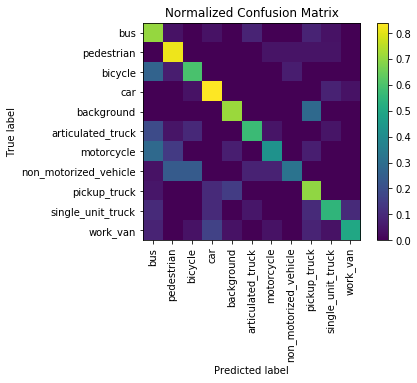





Cross-validation: fold 9
-------------------------------------------------------------------------
Classification Accuracy---------------------------------- 62.33766233766234 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [  2   5   8  36  42  49  51  62  65  70  73  76  83  87  91 100 109 123
 136 149 151 160 163 175 181 185 197 201 226 228]
Groud Truth index [  8  36  42  49  51  62  65  70  73  76  83  87  91 100 104 109 115 123
 134 136 149 151 163 181 197 201 228]
Number of true positives: 24
Number of false positives: 6
Number of false negatives: 3
Precision for bus is 80.0 %
Recall for bus is 88.88888888888889 %
-----------------------------------------------

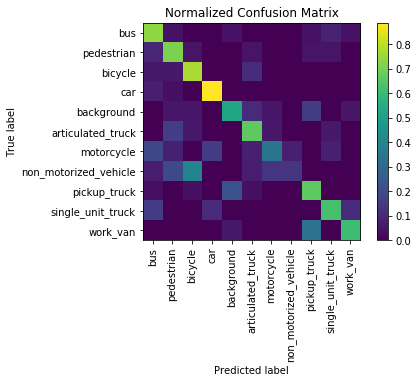





Cross-validation: fold 10
-------------------------------------------------------------------------
Classification Accuracy---------------------------------- 62.77056277056276 %
------------------------------------------------------------------------

Calculation for Precision and Recall:
-------------------------------------------------------------------
Number of Ground Truth of current class 231
Number of Prediction of current class 231
---------------------------------------------------------------
Current class:  bus
Prediction index [  1  10  18  22  23  25  27  34  45  48  49  50  55  74  87 101 103 106
 121 151 170 180 184 200 207 209 222 229]
Groud Truth index [ 10  22  23  25  34  48  50  52  55  74  87 101 103 106 108 121 151 163
 170 175 180 184 195 200 222]
Number of true positives: 20
Number of false positives: 8
Number of false negatives: 5
Precision for bus is 71.42857142857143 %
Recall for bus is 80.0 %
--------------------------------------------------------------

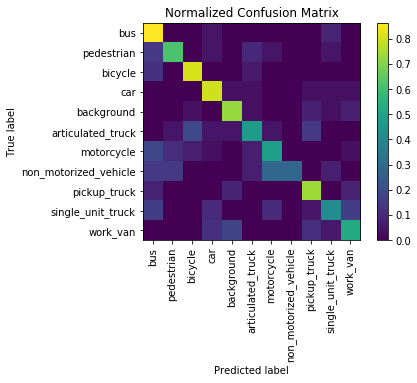

In [34]:
# knn classifier
# cross validation

# Initialize the class with the number of folds:
kf_splitter = KFold(n_splits=10)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

a = 0
accuracy_array = np.zeros(10)
precision_matrix = np.zeros((10, 11))
recall_matrix = np.zeros((10, 11))
total_prediction = []
total_GT = []

# train_index= 9/10 X_train; valid_index =  1/10 X_train
for train_index, valid_index in kf_splitter.split(X_train):   #10
    #print(valid_index[0])
    # Get our training data in this fold
    kX_train = X_train[train_index, :]  # all training images
    kY_train = Y_train[train_index]     # all training labels
    
    # Get our validation data in this fold
    kX_valid = X_train[valid_index, :]   # all testing images
    kY_valid = Y_train[valid_index]      # all testing labels
    
    # Hog 
    kX_train = HOG (kX_train)
    knn.fit(kX_train, kY_train)
    
    kX_valid= HOG (kX_valid)
    
    # knn predict
    prediction_valid = knn.predict(kX_valid)
    
    print("Cross-validation: fold", str(a+1))
    print("-------------------------------------------------------------------------")
    
    # cast 1d array to list 
    kY_valid = toList(kY_valid)
    prediction_valid = toList(prediction_valid)
    
    # for accuracy calculation
    acc = accuracy (kY_valid, prediction_valid)
    print("Classification Accuracy----------------------------------", acc*100, "%")
    print("------------------------------------------------------------------------\n")
    print("Calculation for Precision and Recall:")
    print("-------------------------------------------------------------------")
  
    precision, recall = compute_precision_recall(kY_valid, prediction_valid)
    
    accuracy_array[a] = acc
    precision_matrix[a, :] = precision
    recall_matrix[a, :] = recall
    
    a = a+1

    # print the confusion matrix
    conf (kY_valid, prediction_valid, names)
    print("\n")
    print("\n")
  

In [36]:
# print out the overall result, includes: average accuracy, precision and recall for each class

print("Average accuracy across validations:", np.mean(accuracy_array)*100, "%") 
print("Standard deviation:", np.std(accuracy_array))

print("\n")
print("Average precision and recall across validations for each class:") 

average_precision = precision_matrix.mean(0)
average_recall = recall_matrix.mean(0)
for i in range(11):
    print("----------------------------------------------------------------------")
    print("Current class:", names[i])
    print("Average precision:", average_precision[i]*100, "%")
    print("Average recall:", average_recall[i]*100, "%")

Average accuracy across validations: 62.55411255411255 %
Standard deviation: 0.043688641123784316


Average precision and recall across validations for each class:
----------------------------------------------------------------------
Current class: bus
Average precision: 64.16501472383825 %
Average recall: 78.22422891118543 %
----------------------------------------------------------------------
Current class: pedestrian
Average precision: 86.17973856209152 %
Average recall: 36.05047992113221 %
----------------------------------------------------------------------
Current class: bicycle
Average precision: 60.45209888109847 %
Average recall: 69.23719336219337 %
----------------------------------------------------------------------
Current class: car
Average precision: 63.294648829431445 %
Average recall: 70.68764486287706 %
----------------------------------------------------------------------
Current class: background
Average precision: 62.58456813904708 %
Average recall: 65.880316175